In [1]:
import os

import torch
import pytorch_lightning as pl
print('torch version: ', torch.__version__)
cuda_no = "cuda:7"
device = torch.device(cuda_no if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
print(device)

from hydra.experimental import initialize, compose
from hydra.utils import instantiate

torch version:  1.8.1+cu102
cuda:7


In [2]:
import numpy as np
import time 
import matplotlib.pyplot as plt
%matplotlib inline

from einops import rearrange

In [3]:
from bliss import sleep
from bliss.datasets import simulated, sdss

from bliss.models.location_encoder import (
    get_full_params_from_tiles,
    get_images_in_tiles,
    subtract_bg_and_log_transform,
)

torch.manual_seed(345245)
np.random.seed(3498)

In [4]:
import sys
sys.path.append('../starnet_utils/')
import plotting


# config

In [30]:
###################
# load config parameters 
###################
with initialize(config_path='./../decaps/scripts/'):
    cfg = compose("decaps")
    
       
print('config: ')
print(cfg)


config: 
{'mode': 'train', 'gpus': 1, 'paths': {'root': None, 'output': '${paths.root}/output', 'sdss': '${paths.root}/data/sdss', 'data': '${paths.root}/data'}, 'datasets': {'simulated_m2': {'_target_': 'bliss.datasets.simulated.SimulatedDataset', 'prior': '${models.prior}', 'decoder': '${models.decoder}', 'background': [667.0, 496.0], 'n_batches': 40, 'batch_size': 4, 'generate_device': 'cuda:0', 'testing_file': None}}, 'models': {'decoder': {'_target_': 'bliss.models.decoder.ImageDecoder', 'n_bands': 2, 'tile_slen': 10, 'ptile_slen': 30, 'border_padding': 5, 'psf_params_file': '../psf/ziband_psf_fitted.npy', 'sdss_bands': [2, 3]}, 'encoder': {'_target_': 'bliss.models.location_encoder.LocationEncoder', 'n_bands': '${models.decoder.n_bands}', 'tile_slen': '${models.decoder.tile_slen}', 'ptile_slen': 20, 'max_detections': 3, 'channel': 17, 'spatial_dropout': 0.11399, 'dropout': 0.013123, 'hidden': 185}, 'prior': {'_target_': 'bliss.models.prior.ImagePrior', 'n_bands': 2, 'slen': 300, 

/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/initialize.py:35: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  warnings.warn(
/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/hydra/experimental/compose.py:16: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  warnings.warn(


In [31]:
# cfg.models.prior.update({'slen': 20})

In [32]:
cfg.datasets.simulated_m2.update({'generate_device': cuda_no})

In [33]:
cfg.models.decoder.update({'psf_params_file': '../decaps/psf/ziband_psf_fitted.npy'})

# Initialize

In [34]:
###################
# initialize data set and model
###################
dataset = instantiate(cfg.training.dataset)
sleep_net = instantiate(cfg.training.model,
                        optimizer_params=cfg.training.optimizer_params)
trainer = instantiate(cfg.training.trainer)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [35]:
batch = dataset.get_batch()

images = batch['images'].to(device)
background = batch['background'].to(device)

sleep_net.to(device);

In [36]:
%matplotlib inline

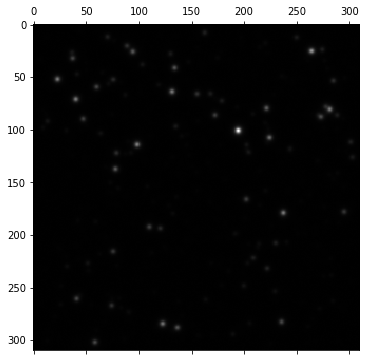

In [37]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))

batch = dataset.get_batch()

plotting.plot_image(ax,
                    batch['images'][0, 0].cpu())

In [39]:
model_filename = './../decaps/fits/starnet-tmp'

sleep_net = instantiate(cfg.training.model,
                        optimizer_params=cfg.training.optimizer_params)

sleep_net.image_encoder.load_state_dict(torch.load(model_filename)); 

# Test out a few images

In [40]:
def get_map_estimate(image_encoder, images, background, slen: int, wlen: int = None):
    # return full estimate of parameters in full image.
    # NOTE: slen*wlen is size of the image without border padding

    if wlen is None:
        wlen = slen
    assert isinstance(slen, int) and isinstance(wlen, int)
    # check image compatibility
    border1 = (images.shape[-2] - slen) / 2
    border2 = (images.shape[-1] - wlen) / 2
    assert border1 == border2, "border paddings on each dimension differ."
    assert slen % image_encoder.tile_slen == 0, "incompatible slen"
    assert wlen % image_encoder.tile_slen == 0, "incompatible wlen"
    assert border1 == image_encoder.border_padding, "incompatible border"

    # obtained estimates per tile, then on full image.
    log_images = subtract_bg_and_log_transform(images, background)
    log_image_ptiles = get_images_in_tiles(
        log_images, image_encoder.tile_slen, image_encoder.ptile_slen
    )
    var_params = image_encoder.encode(log_image_ptiles)
    # var_params2 = image_encoder.encode(log_image_ptiles[:, :25, :25])
    # assert torch.allclose(var_params[0, :25, :25], var_params2, atol=1e-5)
    tile_map = image_encoder.max_a_post(var_params)

    return get_full_params_from_tiles(tile_map, image_encoder.tile_slen)

In [42]:
dataset.background

tensor([667., 496.], device='cuda:7')

In [43]:
sleep_net.train();

for i in range(20): 
    batch = dataset.get_batch()
    tmp = batch['images'].to(device)
    map_est_sleep = get_map_estimate(sleep_net.image_encoder,
                                     tmp,
                                     dataset.background.view(1, 2, 1, 1).to(device), 
                                     slen = 10)

AssertionError: incompatible border

In [ ]:
tmp.shape

In [16]:
sleep_net.image_encoder.to(device);
sleep_net.image_encoder.eval(); 

In [17]:
batch = dataset.get_batch()
tmp = batch['images'].to(device)
map_est_sleep = get_map_estimate(sleep_net.image_encoder,
                                 tmp,
                                 dataset.background.view(1, 1, 1, 1).to(device), 
                                 slen = 10)

In [18]:
(batch['n_sources'].squeeze() == map_est_sleep['n_sources'].squeeze()).float().mean()

tensor(0.9219, device='cuda:7')

In [136]:
def get_var_params(image_encoder, images, background, n_sources, slen: int, wlen: int = None):
    # return full estimate of parameters in full image.
    # NOTE: slen*wlen is size of the image without border padding

    if wlen is None:
        wlen = slen
    assert isinstance(slen, int) and isinstance(wlen, int)
    # check image compatibility
    border1 = (images.shape[-2] - slen) / 2
    border2 = (images.shape[-1] - wlen) / 2
    assert border1 == border2, "border paddings on each dimension differ."
    assert slen % image_encoder.tile_slen == 0, "incompatible slen"
    assert wlen % image_encoder.tile_slen == 0, "incompatible wlen"
    assert border1 == image_encoder.border_padding, "incompatible border"

    # obtained estimates per tile, then on full image.
    log_images = subtract_bg_and_log_transform(images, background)
    log_image_ptiles = get_images_in_tiles(
        log_images, image_encoder.tile_slen, image_encoder.ptile_slen
    )
    var_params = image_encoder.encode(log_image_ptiles)
    var_params_flat = rearrange(var_params, "b nth ntw d -> (b nth ntw) d")
    
    pred = image_encoder.encode_for_n_sources(var_params_flat, n_sources.squeeze().unsqueeze(0))
    
    return(pred)

In [149]:
def ex_image_at_delta(delta): 
    dataset.batch_size = 2000
    batch = dataset.get_batch()
    
    n_sources = batch['n_sources'] * 0 + 1
    # fluxes = dataset.image_prior._draw_pareto_maxed(batch["fluxes"].shape)
    fluxes = batch['fluxes'] * 0 + 5000
    
    locs = batch['locs']
    locs[:, :, :, 0, :] = 0.5 
    locs[:, :, :, 1, :] = 0.5 
    
    images = dataset.image_decoder.render_images(
                n_sources,
                locs,
                batch["galaxy_bools"],
                batch["galaxy_params"],
                fluxes
            )


    background = dataset.make_background(*images.shape)
    images += background
    images = dataset._apply_noise(images)
        
    return images, n_sources

In [155]:
def deblend_at_delta(delta): 
    images, n_sources = ex_image_at_delta(delta)
    
    map_est_sleep = get_var_params(sleep_net.image_encoder,
                                   images,
                                   dataset.background.view(1, 1, 1, 1).to(device), 
                                                                      n_sources, 
                                   slen = 10)
    
    return map_est_sleep, batch

In [156]:
delta_vec = np.linspace(0.4, 0.6, 21)
delta_vec

array([0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ,
       0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 ])

In [157]:
probs2 = torch.zeros(len(delta_vec))

for i in range(len(delta_vec)): 
    map_est, batch = deblend_at_delta(delta_vec[i])

In [158]:
map_est['n_source_log_probs'][:, 0].exp()

tensor([0.0002, 0.0003, 0.0002,  ..., 0.0004, 0.0002, 0.0002], device='cuda:7',
       grad_fn=<ExpBackward>)

In [159]:
map_est['n_source_log_probs'][:, 1].exp()

tensor([0.8680, 0.9185, 0.9143,  ..., 0.7573, 0.8932, 0.9056], device='cuda:7',
       grad_fn=<ExpBackward>)

In [145]:
example_images = torch.zeros(len(delta_vec), 20, 20)

for i in range(len(delta_vec)): 
    
    image_i = ex_image_at_delta(delta_vec[i])[0]
    
    example_images[i] = image_i[0, 0, :, :]

/tmp/ipykernel_1941725/1982724383.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(1, 1, figsize=(5, 3))


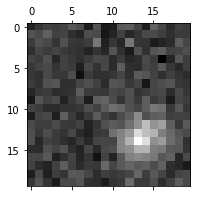

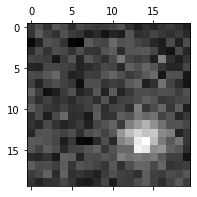

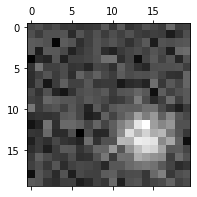

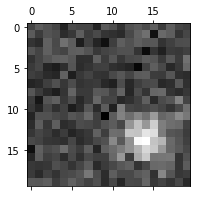

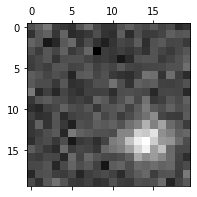

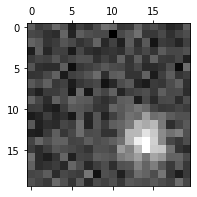

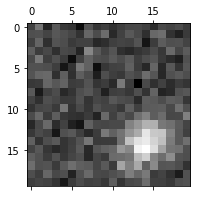

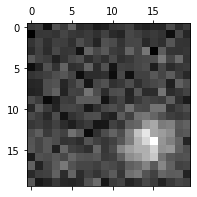

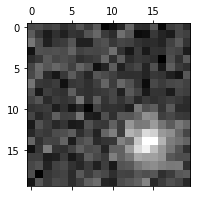

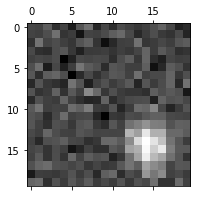

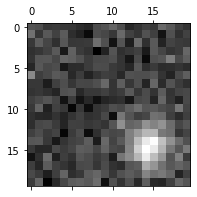

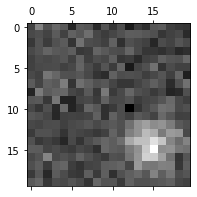

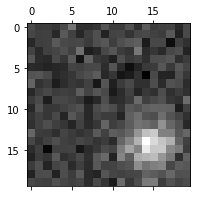

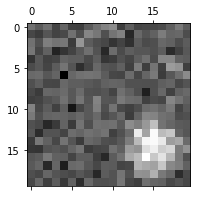

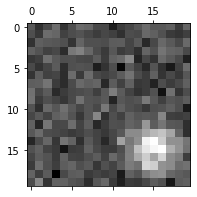

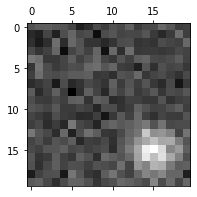

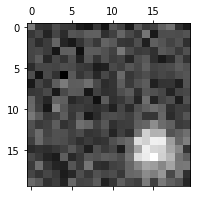

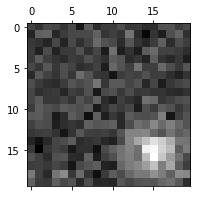

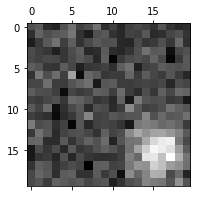

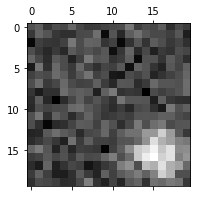

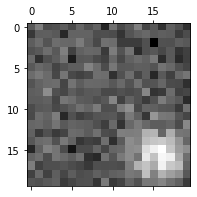

In [146]:
for i in range(len(delta_vec)): 
    
    f, ax = plt.subplots(1, 1, figsize=(5, 3))

    plotting.plot_image(ax,
                        example_images[i])
    
#     ax.set_title('delta = {:.2f}; prob(2) = {:.2f}'.format(delta_vec[i], 
#                                                            probs2.numpy()[i]))